## Preamble

In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

In [2]:
nz=201; nx=201; h=10

fpeak=7
dt=0.002
nt=2000

ntr=100

In [3]:
def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

# def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=26):
#     tmp=np.fromfile(filename,dtype='float32').reshape(n).T
#     return tmp[:,:,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/FWI',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}

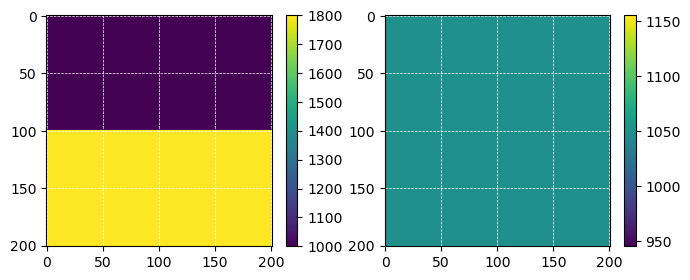

In [4]:
# True
!makevel nz=100 nx=$nx v000=1000 > c1
!makevel nz=101 nx=$nx v000=1800 > c2
!cat c1 c2 > tmp && transp < tmp n1=$nx > true
!rm c1 c2 tmp

# Background
!makevel nz=$nz nx=$nx v000=1050 > init

#plot
plt.figure(figsize=(8,3))
true=read('true'); init=read('init')
plt.subplot(1,2,1); imshow(true)
plt.subplot(1,2,2); imshow(init)

In [5]:
!cat setup_default

MODEL_SIZE              '201 201 1'
MODEL_SPACING           '10 10 1'
FILE_MODEL              true
MODEL_ATTRIBUTES        vp  #'vp rho'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '40 500  0'
DR                      '0  20   0'
FR                      '40 0    0'
NR                      100

SCOMP                   pz
RCOMP                   'pz px ez ex es'

WAVELET_TYPE            ricker

IF_BLOOM        F
IF_HICKS        F

IF_USE_RANDOM   F

NT           2000
DT           0.002
FPEAK        7
#RDT			0.006

#SNAPSHOT     'pz px ez ex'
#NSNAPSHOT    50

## for FWI ##
FILE_DATA_PREFIX    'results_obs/Ru_Shot'

WEIGHTING    'aoffset_range:1000:1000'

JOB           gradient


IF_USE_CHECKPOINT   F


## Obs & Syn data

In [6]:
!cp setup_default setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 610056 Nov  8 21:59 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 21:59:09
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx
Req

In [7]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 610056 Nov  8 21:59 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 21:59:21
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx
Req

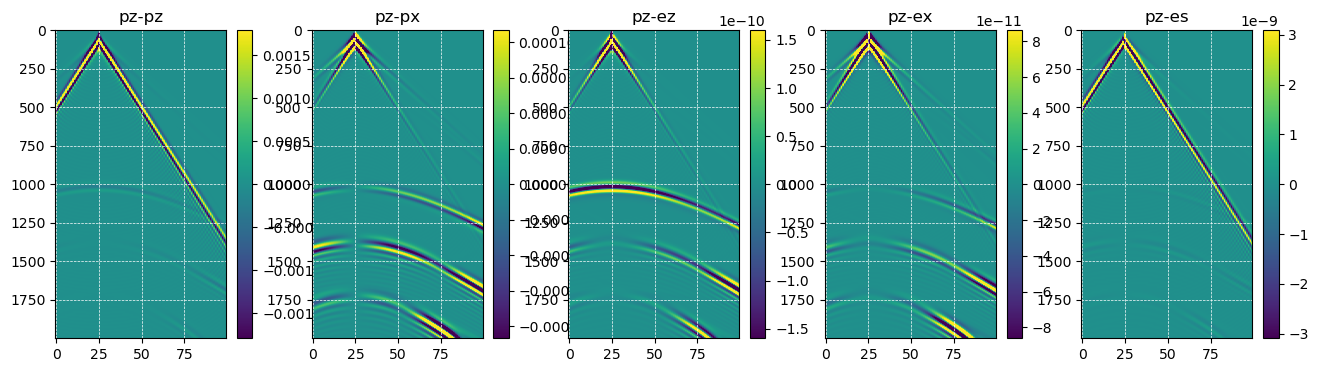

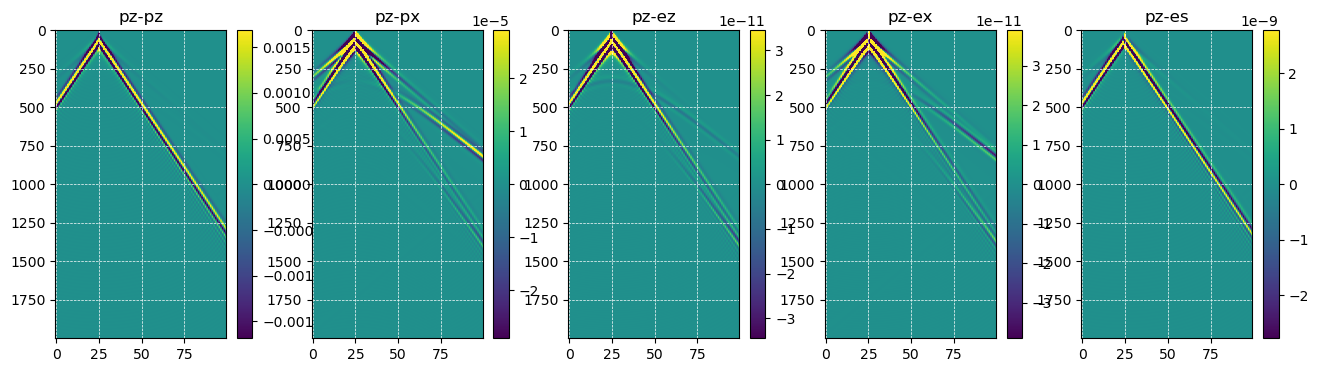

In [8]:
data=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))

plt.figure(figsize=(16,4))
plt.subplot(1,5,1); imshow(data[:,     :ntr],title='pz-pz',perc=98)
plt.subplot(1,5,2); imshow(data[:,  ntr:2*ntr],title='pz-px',perc=98)
plt.subplot(1,5,3); imshow(data[:,2*ntr:3*ntr],title='pz-ez',perc=98)
plt.subplot(1,5,4); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)
plt.subplot(1,5,5); imshow(data[:,4*ntr:5*ntr],title='pz-es',perc=98)

data=read_su('results_syn/Ru_Shot0001.su',n=(5*ntr,nt))

plt.figure(figsize=(16,4))
plt.subplot(1,5,1); imshow(data[:,     :ntr],title='pz-pz',perc=98)
plt.subplot(1,5,2); imshow(data[:,  ntr:2*ntr],title='pz-px',perc=98)
plt.subplot(1,5,3); imshow(data[:,2*ntr:3*ntr],title='pz-ez',perc=98)
plt.subplot(1,5,4); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)
plt.subplot(1,5,5); imshow(data[:,4*ntr:5*ntr],title='pz-es',perc=98)

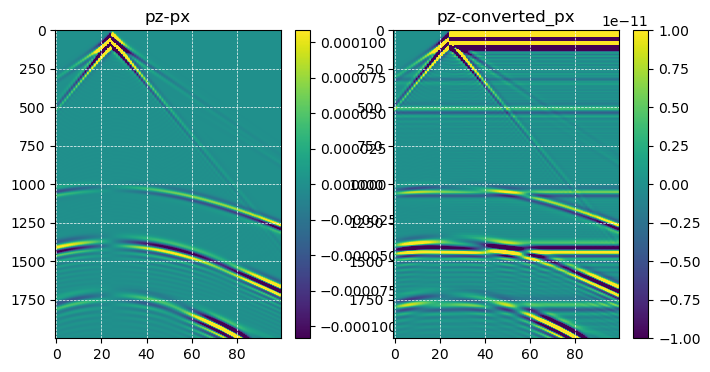

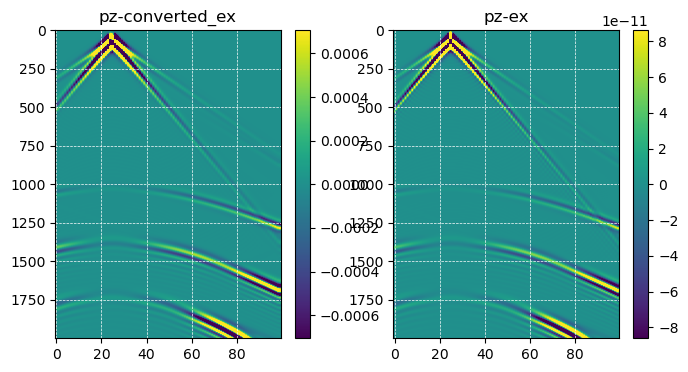

In [30]:
data=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(data[:,ntr:2*ntr],title='pz-px',perc=98)
plt.subplot(1,2,2); imshow(np.gradient(np.cumsum(data[:,3*ntr:4*ntr],axis=1),axis=0),
                           title='pz-converted_px',clip=(-1e-11,1e-11))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)
plt.subplot(1,2,2); imshow(np.cumsum(np.gradient(data[:,ntr:2*ntr],axis=1),axis=0),
                           title='pz-converted_ex',perc=98)


# data=read_su('results_syn/Ru_Shot0001.su',n=(5*ntr,nt))

# plt.figure(figsize=(16,4))
# plt.subplot(1,3,1); imshow(data[:,ntr:2*ntr],title='pz-px',perc=98)
# plt.subplot(1,3,2); imshow(-np.gradient(data[:,ntr:2*ntr],axis=1),title='neg pz-dx_px',perc=98)
# plt.subplot(1,3,3); imshow(data[:,3*ntr:4*ntr],title='pz-ex',perc=98)

In [9]:
#case (11); self%rcv(i)%comp='p'  !pressure

#case (12); self%rcv(i)%comp='vz' !vertical velocity
#case (14); self%rcv(i)%comp='vx' !horizontal velocity in in-line
#case (13); self%rcv(i)%comp='vy' !horizontal velocity in cross-line

#case (21); self%rcv(i)%comp='ez' !ezz
#case (22); self%rcv(i)%comp='ex' !exx
#case (23); self%rcv(i)%comp='ey' !eyy
#case (24); self%rcv(i)%comp='es' !ezx

#case (32); self%rcv(i)%comp='pz' !vertical momenta
#case (34); self%rcv(i)%comp='px' !in-line momenta
#case (33); self%rcv(i)%comp='py' !cross-line momenta

In [10]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
vp=init
vs=vp/np.sqrt(3)
rho=1000.
def gvp(glda):     return  glda            *2*rho*vp
def gvs(glda,gmu): return (glda*(-2) + gmu)*2*rho*vs

## Momentum-Strain formulation

### pz-pz

In [11]:
!suwind < results_obs/Ru_Shot0001.su key=trid min=32 max=32 > data_0001.su

!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo 'FILE_DATA_PREFIX   data_' >> setup
!echo "DIR_OUT     results_pe" >> setup
run(app='../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 842320 Nov  8 21:57 ../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 22:00:16
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_pe
 Output directory:results_pe/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
  

 it----         500
 fld_a minmax values:  -1.35773462E-05   1.12594334E-05
 fld_u minmax values:  -3.47582228E-03   3.53789120E-03
 Elapsed time to load boundary               8.15820694E-03
 Elapsed time to update strains             0.787008762    
 Elapsed time to rm source strains           2.17771530E-03
 Elapsed time to update momenta              1.02123785    
 Elapsed time to rm source momenta           2.20823288E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       3.77225876E-03
 Elapsed time to update adj strains         0.789340496    
 Elapsed time to add adjsource momenta       5.74207306E-03
 Elapsed time to update adj momenta          1.00632572    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   1.69625282E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


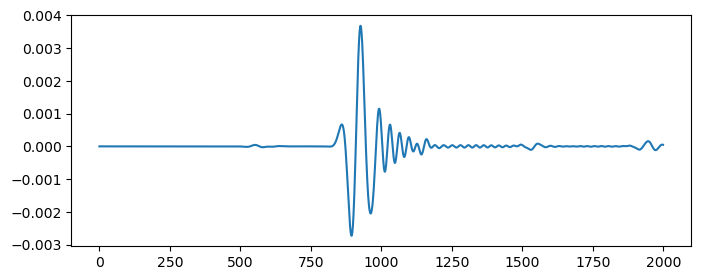

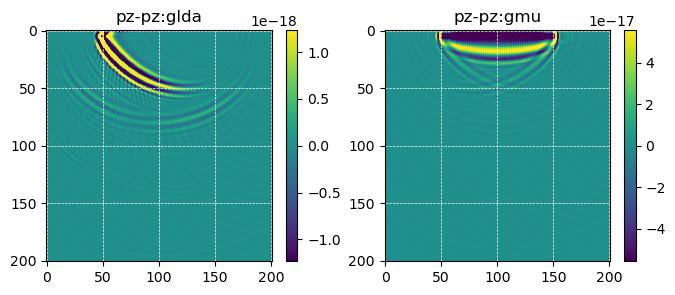

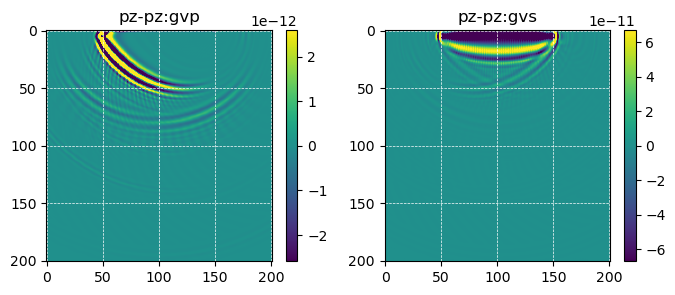

In [12]:
comp='pz-pz'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_pe/dadj_Shot0001.su')[:,75])

glda=read('results_pe/a_star_u%glda')
gmu =read('results_pe/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

### pz-px

In [48]:
!suwind < results_obs/Ru_Shot0001.su key=trid min=34 max=34 > data_0001.su

!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo 'FILE_DATA_PREFIX   data_' >> setup
!echo "DIR_OUT     results_PE_pz-px" >> setup
run(app='../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 842320 Nov  8 22:00 ../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 23:35:17
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_PE_pz-px
 Output directory:results_PE_pz-px/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell

 it----         500
 fld_a minmax values:  -3.40225029E-07   3.91481308E-07
 fld_u minmax values:  -3.47582228E-03   3.53789120E-03
 Elapsed time to load boundary               8.09288025E-03
 Elapsed time to update strains             0.781520844    
 Elapsed time to rm source strains           2.06375122E-03
 Elapsed time to update momenta              1.01355791    
 Elapsed time to rm source momenta           1.98888779E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       3.71885300E-03
 Elapsed time to update adj strains         0.783534527    
 Elapsed time to add adjsource momenta       4.27770615E-03
 Elapsed time to update adj momenta          1.00855494    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   1.70073509E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


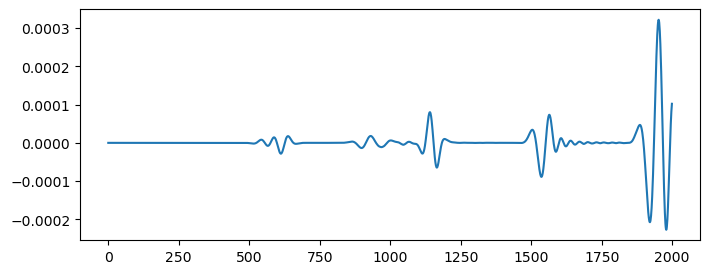

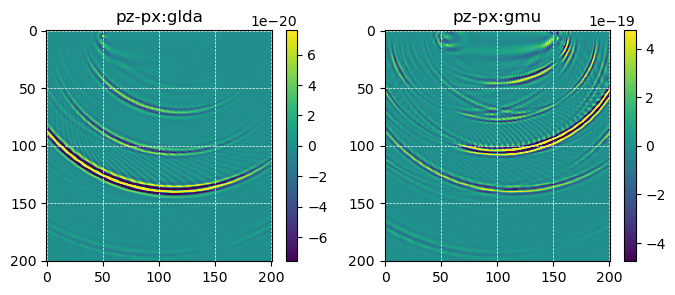

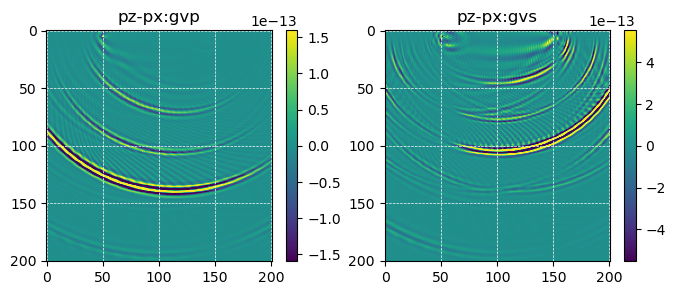

In [14]:
comp='pz-px'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_PE_pz-px/dadj_Shot0001.su')[:,75])

glda=read('results_PE_pz-px/a_star_u%glda')
gmu =read('results_PE_pz-px/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

### pz-ex

In [17]:
!suwind < results_obs/Ru_Shot0001.su key=trid min=22 max=22 > data_0001.su

!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo 'FILE_DATA_PREFIX   data_' >> setup
!echo "DIR_OUT     results_pe" >> setup
run(app='../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 842320 Nov  8 22:00 ../../exe/fwi_DAS_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 22:45:29
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_pe
 Output directory:results_pe/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
  

 it----         500
 fld_a minmax values:  -2.58036769E-19   2.86547565E-19
 fld_u minmax values:  -3.47582228E-03   3.53789120E-03
 Elapsed time to load boundary               7.74431229E-03
 Elapsed time to update strains             0.780750751    
 Elapsed time to rm source strains           2.02369690E-03
 Elapsed time to update momenta              1.00914621    
 Elapsed time to rm source momenta           1.92928314E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       4.49752808E-03
 Elapsed time to update adj strains         0.775068760    
 Elapsed time to add adjsource momenta       2.12764740E-03
 Elapsed time to update adj momenta         0.998368740    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   1.68070793E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


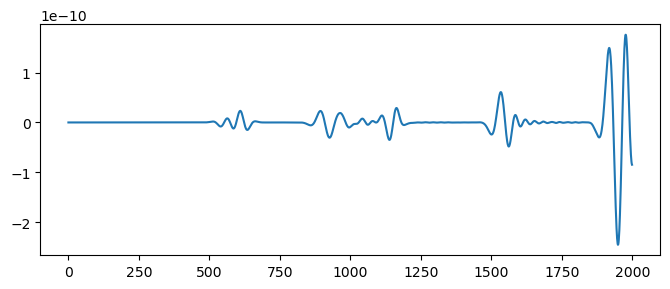

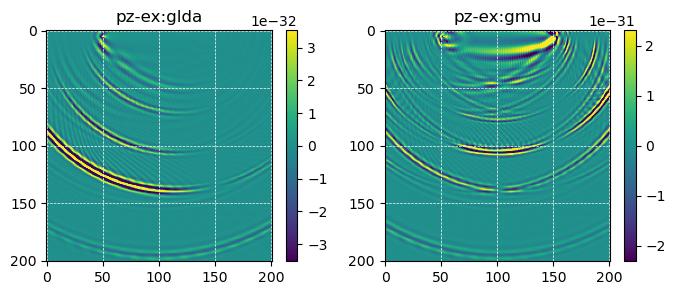

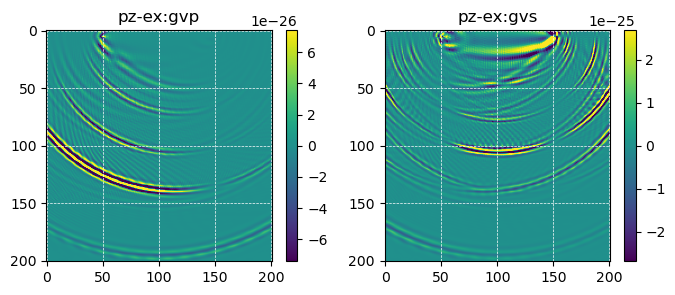

In [18]:
comp='pz-ex'

plt.figure(figsize=(8,3))
plt.plot(read_su('results_pe/dadj_Shot0001.su')[:,75])

glda=read('results_pe/a_star_u%glda')
gmu =read('results_pe/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)

## Velocity-Stress formulation

### Obs

In [43]:
!cp setup_default setup
!echo "DIR_OUT     results_obs_VS" >> setup
!echo 'SCOMP       vz' >> setup
!echo 'RCOMP       vx' >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 601680 Nov  8 23:28 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 23:28:55
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs_VS
 Output directory:results_obs_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/

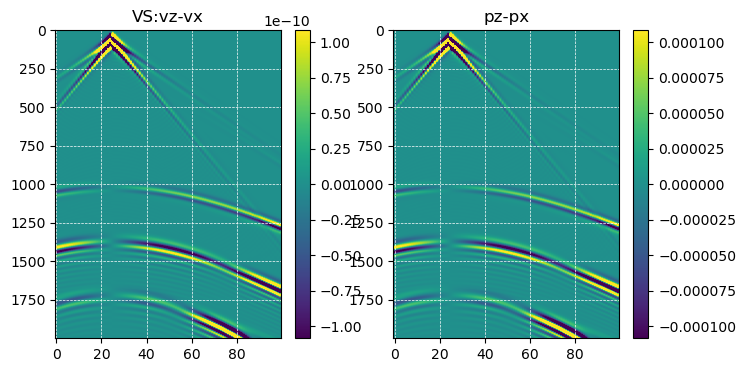

In [47]:
plt.figure(figsize=(8,4))

data=read_su('results_obs_VS/Ru_Shot0001.su',n=(ntr,nt))
plt.subplot(1,2,1); imshow(data,title='VS:vz-vx',perc=98)

data=read_su('results_obs/Ru_Shot0001.su',n=(5*ntr,nt))
plt.subplot(1,2,2); imshow(data[:,ntr:2*ntr],title='pz-px',perc=98)

### vz-vx

In [44]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "FILE_DATA_PREFIX   'results_obs_VS/Ru_Shot'" >> setup
!echo 'SCOMP       vz' >> setup
!echo "DIR_OUT     results_VS" >> setup
run(app='../../exe/fwi_PSV_FDSG_O4_velocities-density_Wolfe_NLCG')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/joey/Codes/GitHub/SeisJIMU/Demo/05_FWIgradient
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 joey joey 833944 Nov  8 23:27 ../../exe/fwi_PSV_FDSG_O4_velocities-density_Wolfe_NLCG
 Git Commit: 0dae357
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/08/2023
System time: 23:29:48
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI        
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_VS
 Output directory:results_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
  

 it----         500
 fld_a minmax values:  -3.40225073E-19   3.91481733E-19
 fld_u minmax values:  -3.47582252E-09   3.53789176E-09
 Elapsed time to load boundary               7.62677193E-03
 Elapsed time to update stresses            0.671060085    
 Elapsed time to rm source stresses          1.74260139E-03
 Elapsed time to update velocities          0.567243814    
 Elapsed time to rm source velocities        1.97005272E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource stresses      1.84726715E-03
 Elapsed time to update adj stresses        0.664476633    
 Elapsed time to add adjsource velocities    3.63874435E-03
 Elapsed time to update adj velocities      0.558639288    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   2.80897617E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


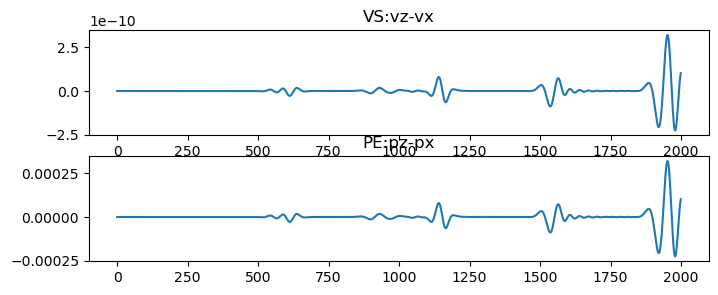

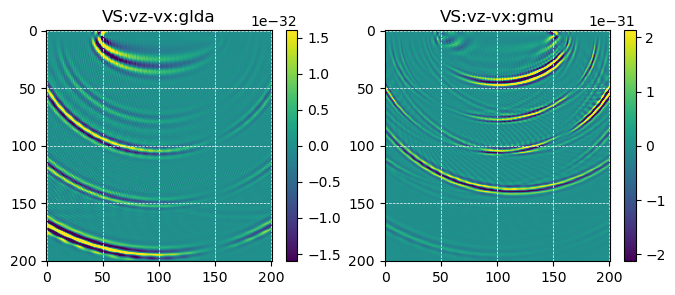

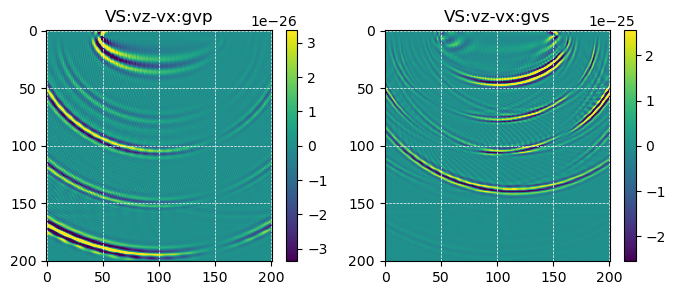

In [50]:
comp='VS:vz-vx'

plt.figure(figsize=(8,3))
plt.subplot(2,1,1); plt.plot(read_su('results_VS/dadj_Shot0001.su')[:,75]); plt.title(comp)
plt.subplot(2,1,2); plt.plot(read_su('results_PE_pz-px/dadj_Shot0001.su')[:,75]); plt.title('PE:pz-px')

glda=read('results_VS/a_star_u%glda')
gmu =read('results_VS/a_star_u%gmu' )

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(glda,title=comp+':glda',perc=98)
plt.subplot(1,2,2); imshow(gmu ,title=comp+':gmu' ,perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(gvp(glda),title=comp+':gvp',perc=98)
plt.subplot(1,2,2); imshow(gvs(glda,gmu),title=comp+':gvs',perc=98)